## COVID19 Data Analysis

### Imports

In [1]:
import json
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import rcParams
from tqdm import tqdm

plt.style.use('seaborn')
rcParams.update({'figure.autolayout': True})

%matplotlib inline

In [2]:
df = pd.read_csv("Data\\raw_data.csv")

unwanted_columns = [
    'State Patient Number',
    'Estimated Onset Date',
    'Detected City',
    'State code',
    'Notes',
    'Contracted from which Patient (Suspected)',
    'Source_1',
    'Source_2',
    'Source_3',
    'Backup Notes',
]

df.drop(unwanted_columns, axis=1, inplace=True)

df['Date Announced'] = pd.to_datetime(df['Date Announced'], infer_datetime_format=True)
df['Status Change Date'] = pd.to_datetime(df['Status Change Date'], infer_datetime_format=True)
df['Age Bracket'] = pd.to_numeric(df['Age Bracket'], errors='coerce')

df.head()

,Patient Number,Date Announced,Age Bracket,Gender,Detected District,Detected State,Current Status,Nationality,Type of transmission,Status Change Date
0,1,2020-01-30,20.0,F,Thrissur,Kerala,Recovered,India,Imported,2020-02-14
1,2,2020-02-02,NaN,NaN,Alappuzha,Kerala,Recovered,India,Imported,2020-02-14
2,3,2020-02-03,NaN,NaN,Kasaragod,Kerala,Recovered,India,Imported,2020-02-14
3,4,2020-03-02,45.0,M,East Delhi,Delhi,Recovered,India,Imported,2020-03-15
4,5,2020-03-02,24.0,M,Hyderabad,Telangana,Recovered,India,Imported,2020-03-02


### Age Graphs

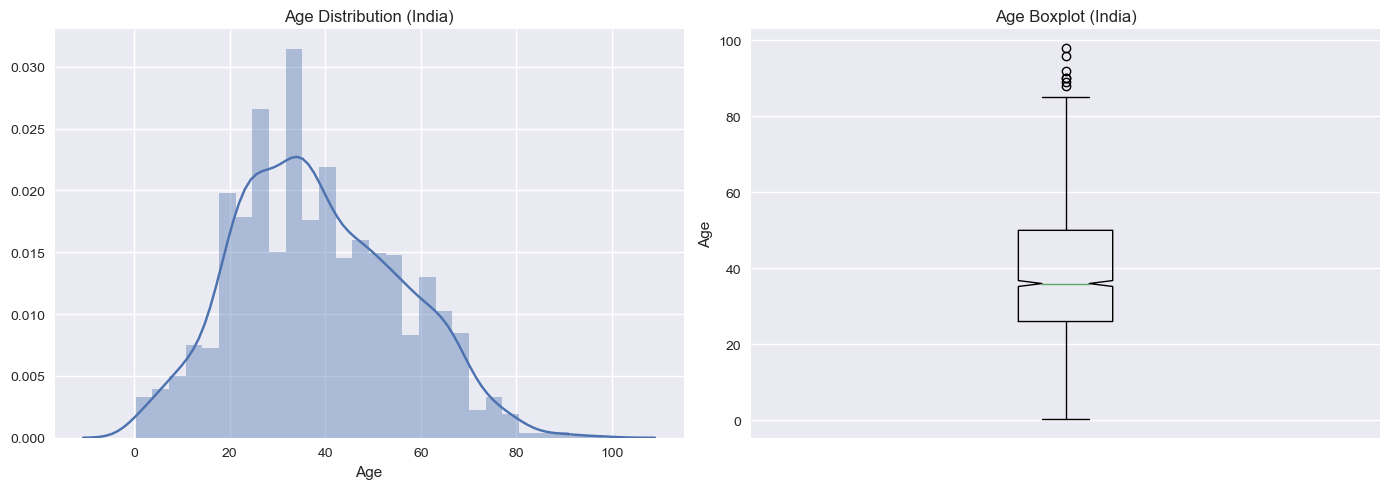

In [3]:
fig = plt.figure(figsize=(14, 5), dpi=100)

plt.subplot(121)
sns.distplot(df['Age Bracket'].dropna(), kde=True)
plt.title('Age Distribution (India)')
plt.xlabel('Age')

plt.subplot(122)
plt.boxplot(df['Age Bracket'].dropna(), notch=True)
plt.title('Age Boxplot (India)')
plt.xticks([0])
plt.ylabel('Age')
plt.savefig('data_insight\\age_distribution.png')
plt.show()

### State Wise Analysis

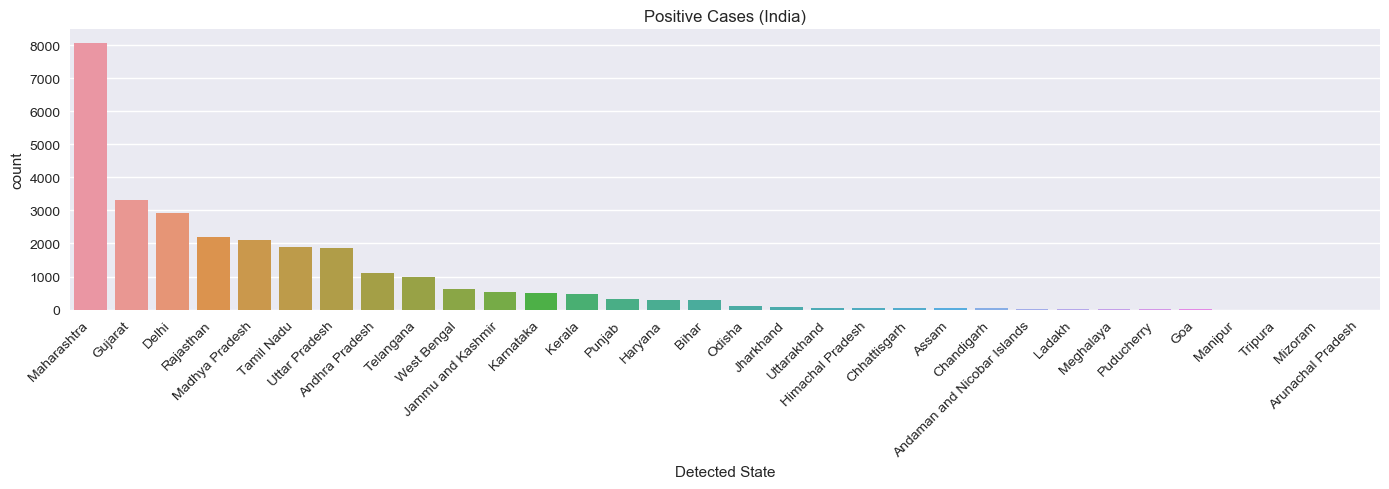

In [4]:
plt.figure(figsize=(14, 5), dpi=100)

statewise_count = sns.countplot(data=df, x=df['Detected State'], order=df['Detected State'].value_counts().index)
statewise_count.set_title('Positive Cases (India)')

statewise_count.set_xticklabels(statewise_count.get_xticklabels(),
                                rotation=45,
                                horizontalalignment='right',
                                fontweight='light')
plt.savefig('data_insight\\cases_statewise.png')
plt.show()

### City Wise Analysis

In [5]:
def plot_city_wise(df, state):

    df = df[df['Detected State'] == state]

    plt.figure(figsize=(14, 5), dpi=100)

    districtwise_count = sns.countplot(data=df, x=df['Detected District'], order=df['Detected District'].value_counts().index)
    districtwise_count.set_title(f'Positive Cases ({state})')

    districtwise_count.set_xticklabels(districtwise_count.get_xticklabels(),
                                    rotation=45,
                                    horizontalalignment='right',
                                    fontweight='light')

    plt.savefig(f'data_insight\\cases_{state}.png')
    plt.show()

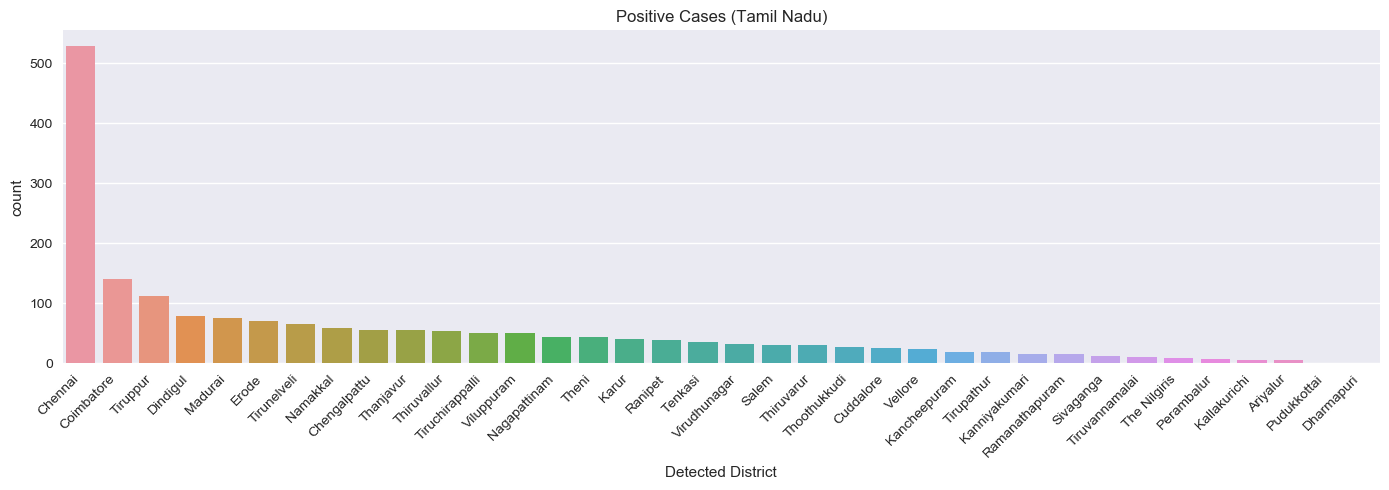

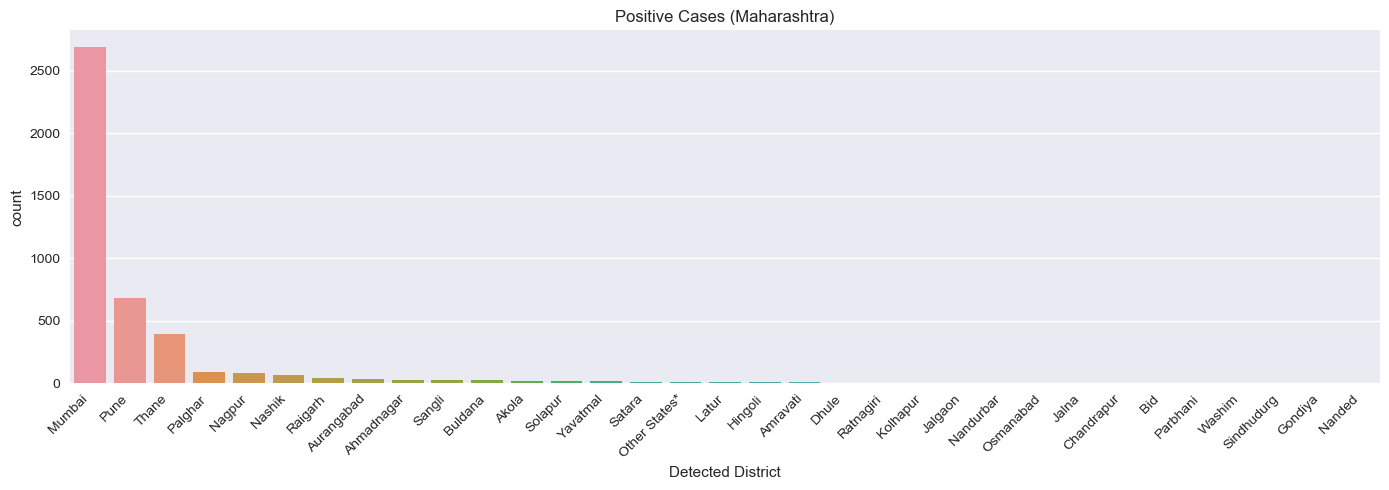

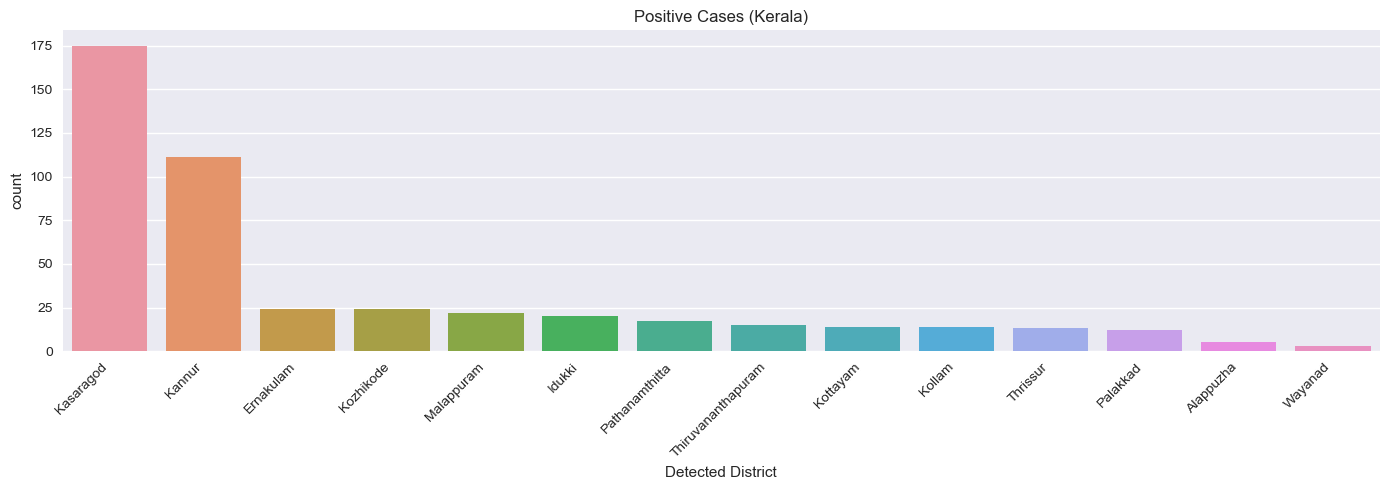

In [6]:
plot_city_wise(df, 'Tamil Nadu')
plot_city_wise(df, 'Maharashtra')
plot_city_wise(df, 'Kerala')

### State Wise Data Analysis

In [7]:
with open('data\\states_daily.json') as f:
    data = json.load(f)

confirmed_df = pd.DataFrame(data['confirmed'])
recovered_df = pd.DataFrame(data['recovered'])
deceased_df = pd.DataFrame(data['deceased'])

def preprocess_df(df):
    df['date'] = pd.to_datetime(df['date'], infer_datetime_format=True)
    df.index = df['date']
    df.drop(['date', 'status'], inplace=True, axis=1)

    for col in df:
        df[col] = pd.to_numeric(df[col])

preprocess_df(confirmed_df)
preprocess_df(recovered_df)
preprocess_df(deceased_df)

def plot_daily_data(df, state, type_):

    fig = sns.barplot(df.index, df[state])
    fig.set_title(f'{type_} Cases ({state})')
    fig.set_ylabel('Number of Cases')

    fig.set_xticklabels(fig.get_xticklabels(),
                        rotation=45,
                        horizontalalignment='right',
                        fontweight='light')
                        
    plt.gca().xaxis.set_major_formatter(plt.FixedFormatter(df.index.to_series().dt.strftime('%d %b %Y')))


def plot_cumulative_data(df, state, type_):
    if type_ == 'Confirmed':
        c = 'r'
    elif type_ == 'Recovered':
        c = 'g'
    elif type_ == 'Deceased':
        c = 'k'
    plt.plot(df.index, df[state], '--o', color=c, alpha=0.7)
    plt.title(f'{type_} Cases (Cumulative - {state})')
    plt.ylabel('Number of Cases')


def plot_data_state(state):

    plt.figure(figsize=(14, 15), dpi=100)

    plt.subplot(311)
    plot_daily_data(confirmed_df, state, 'Confirmed')

    plt.subplot(312)
    plot_daily_data(recovered_df, state, 'Recovered')

    plt.subplot(313)
    plot_daily_data(deceased_df, state, 'Deceased')

    plt.savefig(f'data_insight\\{state}_daily_cases.png')
    # plt.show()
    plt.close()

    cum_confirmed_df = confirmed_df.cumsum()
    cum_recovered_df = recovered_df.cumsum()
    cum_deceased_df = deceased_df.cumsum()

    plt.figure(figsize=(14, 15), dpi=100)

    plt.subplot(311)
    plot_cumulative_data(cum_confirmed_df, state, 'Confirmed')
    plt.subplot(312)
    plot_cumulative_data(cum_recovered_df, state, 'Recovered')
    plt.subplot(313)
    plot_cumulative_data(cum_deceased_df, state, 'Deceased')
    plt.savefig(f'data_insight\\{state}_cumulative.png')
    # plt.show()
    plt.close()
    print(f'[INFO] Plot saved for state: {state}')

In [8]:
for state in tqdm(sorted(data['confirmed'][0].keys())):
    if state != 'date' and state != 'status':
        plot_data_state(state)
        

100%|██████████| 40/40 [01:24<00:00,  2.12s/it][INFO] Plot saved for state: wb

